## 3.1线性回归

### 3.1.2矢量化加速

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [4]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.21993 sec'

In [6]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00100 sec'

### 3.1.3正态分布与平方损失

In [7]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

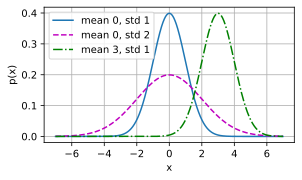

In [8]:
x = np.arange(-7, 7, 0.01)
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 3.2 线性回归的从零开始实现

In [9]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1生成数据集

    y = Xw + b + ϵ 

In [10]:
def synthetic_data(w, b, num_examples): #@save
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [12]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [13]:
print('features:',features[0],'\nlabel:', labels[0])

features: tensor([0.9683, 1.1244]) 
label: tensor([2.3088])


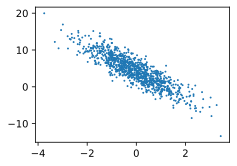

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2读取数据集

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        

In [16]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3792, -0.4535],
        [ 0.4290, -0.5162],
        [-1.4570, -0.8317],
        [ 1.0797, -0.4437],
        [ 1.5077,  0.3940],
        [-1.1657, -0.7698],
        [ 0.2042,  0.0723],
        [-0.4235,  0.6120],
        [ 1.0983, -1.3458],
        [-1.0955,  0.1373]]) 
 tensor([[ 6.4931],
        [ 6.8229],
        [ 4.1326],
        [ 7.8787],
        [ 5.8729],
        [ 4.4846],
        [ 4.3593],
        [ 1.2697],
        [10.9726],
        [ 1.5419]])


### 3.2.3初始化模型参数

In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4定义模型

In [21]:
def linreg(X, w, b): #@save
    return torch.matmul(X, w) + b

### 3.2.5定义损失函数

In [18]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6定义优化算法

In [19]:
def sgd(params, lr, batch_size): #@save
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            

In [22]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [23]:
for epoch in range(num_epochs):
    for (X, y) in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.025422
epoch 2, loss 0.000104
epoch 3, loss 0.000053


In [24]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0004, 0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


## 3.3线性回归的简单实现

### 3.3.1生成数据集

In [32]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2读取数据集

In [34]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造⼀个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [35]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [36]:
next(iter(data_iter))

[tensor([[-0.6920, -0.4082],
         [ 0.8208,  1.3574],
         [-1.3231, -1.3037],
         [-0.0105, -1.4816],
         [ 0.3312, -0.1241],
         [ 1.4825, -0.3750],
         [-0.4458, -0.5894],
         [ 0.7596, -0.7799],
         [-1.0070,  0.3202],
         [-0.9513,  0.4104]]),
 tensor([[4.2146],
         [1.2361],
         [5.9808],
         [9.2045],
         [5.2578],
         [8.4405],
         [5.3160],
         [8.3808],
         [1.1012],
         [0.9011]])]

### 3.3.3 定义模型

In [37]:
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

### 3.3.4初始化模型参数

In [39]:
net[0]

Linear(in_features=2, out_features=1, bias=True)

In [40]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数

In [44]:
loss = nn.MSELoss()

### 3.3.6定义优化算法

In [42]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 3.3.7 训练

In [45]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000187
epoch 2, loss 0.000098
epoch 3, loss 0.000099


In [46]:
w = net[0].weight.data
print('w的估计误差： ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差： ', true_b - b)

w的估计误差：  tensor([-0.0009, -0.0005])
b的估计误差：  tensor([0.0003])


## 3.4 softmax回归

## 3.5图像分类数据集

### 3.5.1读取数据集

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.6%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



119.3%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
mnist_train[0][0].shape, mnist_train[0][1]

(torch.Size([1, 28, 28]), 9)

In [6]:
def get_fashion_mnist_labels(labels): #@save
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [12]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图⽚张量
            ax.imshow(img.numpy())
        else:
            # PIL图⽚
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

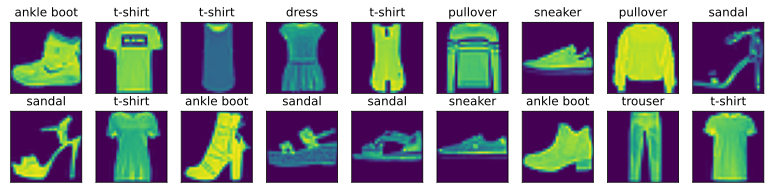

In [13]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

### 3.5.2读取小批量

In [14]:
batch_size = 256

def get_dataloader_workers(): #@save
    return 4

trainloader = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)

In [15]:
timer = d2l.Timer()
for X, y in trainloader:
    continue
f'{timer.stop():.2f} sec'

'8.58 sec'

### 3.5.3整合所有部件

In [16]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4))

In [17]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


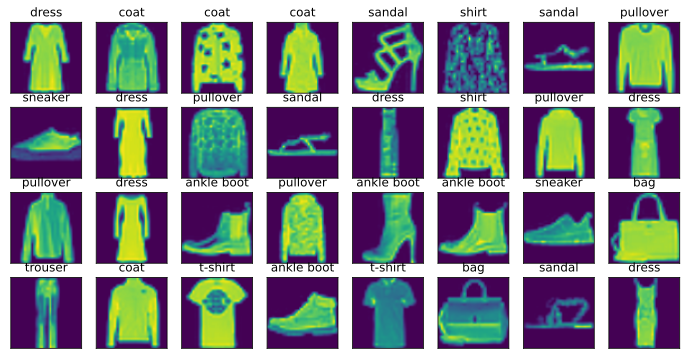

In [20]:
show_images(X.reshape(32, 64, 64), 4, 8, titles=get_fashion_mnist_labels(y));

## 3.6softmax回归的从零开始实现

In [21]:
import torch
from IPython import display
from d2l import torch as d2l

In [22]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.6.1初始化模型参数

In [24]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 3.6.2定义softmax操作

In [25]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [26]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0753, 0.1565, 0.4509, 0.0542, 0.2631],
         [0.0411, 0.1210, 0.2287, 0.5427, 0.0666]]),
 tensor([1.0000, 1.0000]))

### 3.6.3定义模型

In [27]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 3.6.4定义损失函数

In [28]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

### 3.6.5分类精度

In [37]:
def accuracy(y_hat, y): #@save
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [31]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [40]:
evaluate_accuracy(net, test_iter)

0.0766

### 3.6.6训练

In [41]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使⽤PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            # 使⽤定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [48]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使⽤lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [44]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [46]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

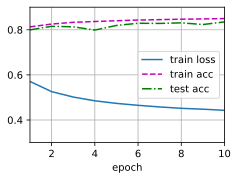

In [49]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)